# Data Collection

In [9]:
!pip install sparqlwrapper

In [10]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import pandas as pd

endpoint_url = "https://query.wikidata.org/sparql"

query = """
  SELECT
  ?governorate
  ?country
  ?clatitude
  ?clongitude
  ?governoratearea
  ?area
  ?population
  ?latitude
  ?longitude
WHERE {

  # Subquery: keep only countries where ALL governorates have population
  {
    SELECT ?countryid
    WHERE {
      ?g wdt:P31/wdt:P279 wd:Q10864048 ;
         wdt:P17 ?countryid .

      OPTIONAL { ?g wdt:P1082 ?pop }
    }
    GROUP BY ?countryid
    HAVING (COUNT(?g) = COUNT(?pop))
  }

  ?countryid wdt:P36 [p:P625 [psv:P625 [wikibase:geoLatitude ?clatitude; wikibase:geoLongitude ?clongitude]]].
  # Main query
  ?governorateid wdt:P31/wdt:P279 wd:Q10864048 ;
                 wdt:P17 ?countryid ;
                 wdt:P625 ?coord ;
                 wdt:P1082 ?population ;
                 wdt:P2046 ?governoratearea .
  ?countryid wdt:P2046 ?area.

  FILTER NOT EXISTS { ?countryid wdt:P31 wd:Q3024240 }

  # Coordinates
  BIND(geof:latitude(?coord) AS ?latitude)
  BIND(geof:longitude(?coord) AS ?longitude)

  # Labels
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "en" .
    ?governorateid rdfs:label ?governorate .
    ?countryid rdfs:label ?country .
  }
}
ORDER BY ?country ?governorate

  """


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)
governorate = []
population = []
country = []
latitude = []
longitude = []
clatitude = []
clongitude = []
governoratearea = []
area = []
for result in results["results"]["bindings"]:
    governorate.append(result["governorate"]["value"])
    country.append(result["country"]["value"])
    population.append(float(result["population"]["value"]))
    latitude.append(float(result["latitude"]["value"]))
    longitude.append(float(result["longitude"]["value"]))
    clatitude.append(float(result["clatitude"]["value"]))
    clongitude.append(float(result["clongitude"]["value"]))
    area.append(float(result["area"]["value"]))
    governoratearea.append(float(result["governoratearea"]["value"]))


# -----------------------------
# Example Data (Replace Yours)
# -----------------------------
# lat, lon in degrees
# population in people

data_all = pd.DataFrame({
    "state": governorate,
    "country": country,
    "lat": latitude,
    "lon": longitude,
    "population": population,
    "area": governoratearea
})

c_lat = dict(zip(country, clatitude))
c_long = dict(zip(country, clongitude))
c_area = dict(zip(country, area))

In [11]:
data_fsi = pd.read_excel("FSI-2023-DOWNLOAD.xlsx")

In [13]:
def search(ls, x):
  try:
    return ls[x]
  except:
    return ""

data_fsi["Capital Latitude"] = data_fsi["Country"].apply(lambda x: search(c_lat, x))
data_fsi["Capital Longitude"] = data_fsi["Country"].apply(lambda x: search(c_long, x))
data_fsi["Area"] = data_fsi["Country"].apply(lambda x: search(c_area, x))



In [15]:
data_fsi = data_fsi[data_fsi["Capital Latitude"] != ""]
data_fsi = data_fsi[data_fsi["Capital Longitude"] != ""]
data_fsi = data_fsi[data_fsi["Area"] != ""]

In [17]:
len(data_fsi["Country"].unique())

55

In [18]:
data_fsi.to_excel("Country_Data.xlsx", index=False)
data_all.to_excel("Governorate_Data.xlsx", index=False)

# Data Analysis: Population as weight

In [19]:
data_fsi = pd.read_excel("Country_Data.xlsx")
data_all = pd.read_excel("Governorate_Data.xlsx")

In [20]:
# -----------------------------
# Haversine Distance (km)
# -----------------------------
def haversine(lat1, lon1, lat2, lon2):
    """
    Compute great-circle distance in km
    """

    R = 6371.0  # Earth radius (km)

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + \
        np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2

    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    pop,
    max_iter=1000,
    tol=1e-6,
):
    """
    Iterative weighted barycenter
    """

    # Initial guess: population-weighted center
    lat_c = np.average(lat, weights=population)
    lon_c = np.average(lon, weights=population)

    for i in range(max_iter):

        # Distances
        d = haversine(lat_c, lon_c, lat, lon)

        # Weights
        w = population

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence test
        delta = np.sqrt(
            (lat_new - lat_c)**2 +
            (lon_new - lon_c)**2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            print(f"Converged in {i+1} iterations")
            break

    return lat_c, lon_c

import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    pop = data["population"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon, srf)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude": bary_lat,
        "bary_longitude": bary_lon,
        "distance_from_capital": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)

Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in

In [21]:
barycenter_df.sort_values(by="distance_from_capital")

,country,bary_latitude,bary_longitude,distance_from_capital
40,Myanmar,19.557031,96.115238,0.025748
27,Iraq,33.397967,44.528982,0.026776
1,Andorra,42.515055,1.522735,0.040307
6,Bangladesh,24.009220,90.266876,0.087890
19,El Salvador,13.692178,-89.058392,0.098966
...,...,...,...,...
53,Slovakia,48.679685,19.113396,0.718879
62,Ukraine,46.986043,36.558385,0.754927
13,Comoros,-11.857738,43.754950,1.268293
30,Kiribati,-0.000170,173.983951,6.548662


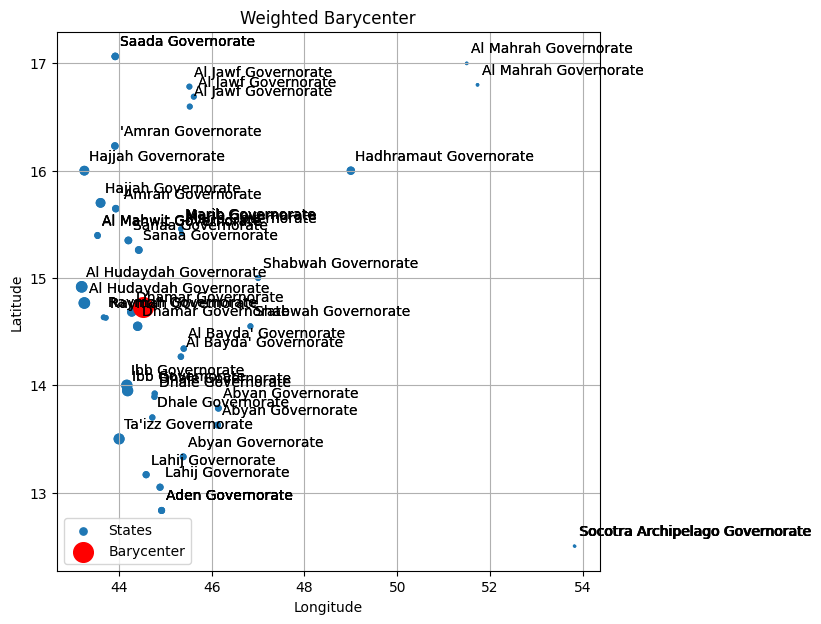

In [22]:
# -----------------------------
# Optional: Visual Check
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [24]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [25]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,C1: Security Apparatus,C2: Factionalized Elites,X1: External Intervention,Capital Latitude,Capital Longitude,Area,country,bary_latitude,bary_longitude,distance_from_capital
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,8.6,9.9,9.2,12.800000,45.033333,4.555030e+05,Yemen,14.730442,44.523137,0.328361
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,9.4,9.9,10.0,33.513056,36.291944,1.851800e+05,Syria,35.035673,37.640113,0.487495
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,9.7,8.7,7.7,34.532778,69.165833,6.522300e+05,Afghanistan,34.429366,68.081284,0.123911
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,9.1,9.0,7.3,19.747500,96.115000,6.765772e+05,Myanmar,19.557031,96.115238,0.025748
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,10.0,8.0,10.0,50.450000,30.523611,6.035500e+05,Ukraine,46.986043,36.558385,0.754927
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,8.1,9.3,6.4,3.857778,11.518056,4.754420e+05,Cameroon,6.150584,11.636560,0.370236
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,6.3,8.9,7.3,0.313611,32.581111,2.410380e+05,Uganda,0.973167,32.250171,0.167128
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,7.5,9.6,7.9,33.315278,44.366111,4.370720e+05,Iraq,33.397967,44.528982,0.026776
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,6.8,8.9,7.5,6.310556,-10.804722,1.113690e+05,Liberia,6.473896,-9.776285,0.344864
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,6.8,8.9,6.9,-1.286389,36.817222,5.813090e+05,Kenya,-0.567517,36.494280,0.114932


# Data Analysis: area as weight

In [29]:

# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    area,
    max_iter=1000,
    tol=1e-6,
):
    """
    Iterative weighted barycenter
    """

    # Initial guess: population-weighted center
    lat_c = np.average(lat, weights=area)
    lon_c = np.average(lon, weights=area)

    for i in range(max_iter):

        # Distances
        d = haversine(lat_c, lon_c, lat, lon)

        # Weights
        w = area

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence test
        delta = np.sqrt(
            (lat_new - lat_c)**2 +
            (lon_new - lon_c)**2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            print(f"Converged in {i+1} iterations")
            break

    return lat_c, lon_c

import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    srf = data["area"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon, srf)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude_area": bary_lat,
        "bary_longitude_area": bary_lon,
        "distance_from_capital_area": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)


Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in

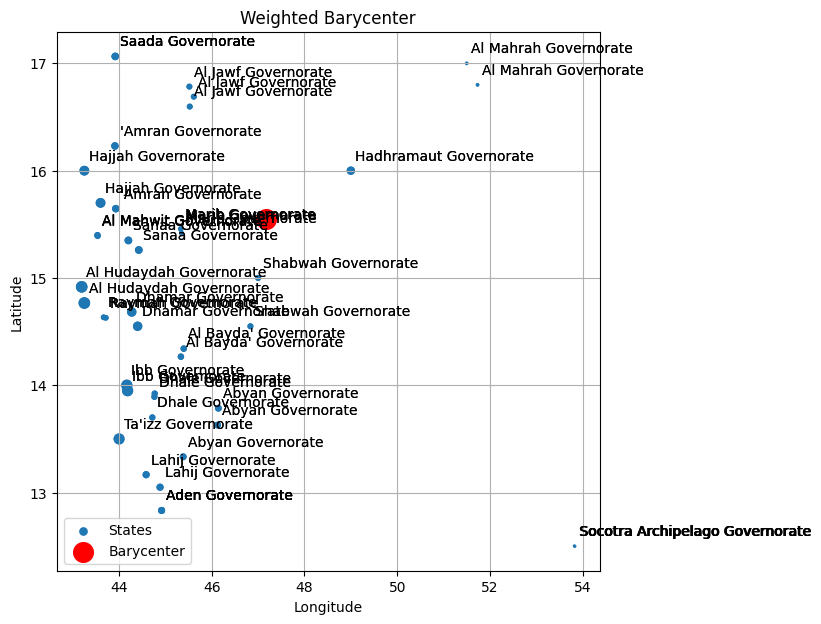

In [30]:
# -----------------------------
# Optional: Visual Check
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [31]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [32]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,Capital Longitude,Area,country_x,bary_latitude,bary_longitude,distance_from_capital,country_y,bary_latitude_area,bary_longitude_area,distance_from_capital_area
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,45.033333,4.555030e+05,Yemen,14.730442,44.523137,0.328361,Yemen,15.552624,47.163284,0.566924
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,36.291944,1.851800e+05,Syria,35.035673,37.640113,0.487495,Syria,35.079524,38.592676,0.636405
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,69.165833,6.522300e+05,Afghanistan,34.429366,68.081284,0.123911,Afghanistan,33.804540,66.137710,0.359218
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,96.115000,6.765772e+05,Myanmar,19.557031,96.115238,0.025748,Myanmar,20.812894,96.519827,0.152899
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,30.523611,6.035500e+05,Ukraine,46.986043,36.558385,0.754927,Ukraine,46.798456,36.344099,0.758774
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,11.518056,4.754420e+05,Cameroon,6.150584,11.636560,0.370236,Cameroon,5.824946,12.455481,0.351176
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.581111,2.410380e+05,Uganda,0.973167,32.250171,0.167128,Uganda,1.367365,32.227467,0.251740
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,44.366111,4.370720e+05,Iraq,33.397967,44.528982,0.026776,Iraq,32.977813,43.756228,0.102947
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-10.804722,1.113690e+05,Liberia,6.473896,-9.776285,0.344864,Liberia,6.422572,-9.309127,0.496661
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,36.817222,5.813090e+05,Kenya,-0.567517,36.494280,0.114932,Kenya,0.280827,37.978089,0.284432


# Data Analysis: Population * Area as weight

In [38]:

# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    area,
    population,
    max_iter=1000,
    tol=1e-6,
):
    """
    Iterative weighted barycenter
    """

    # Initial guess: population-weighted center
    lat_c = np.average(lat, weights=area * population)
    lon_c = np.average(lon, weights=area * population)

    for i in range(max_iter):

        # Distances
        d = haversine(lat_c, lon_c, lat, lon)

        # Weights
        w = area * population

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence test
        delta = np.sqrt(
            (lat_new - lat_c)**2 +
            (lon_new - lon_c)**2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            print(f"Converged in {i+1} iterations")
            break

    return lat_c, lon_c

import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    srf = data["area"].values
    pop = data["population"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon, srf, pop)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude_product": bary_lat,
        "bary_longitude_product": bary_lon,
        "distance_from_capital_product": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)


Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in 1 iterations
Converged in

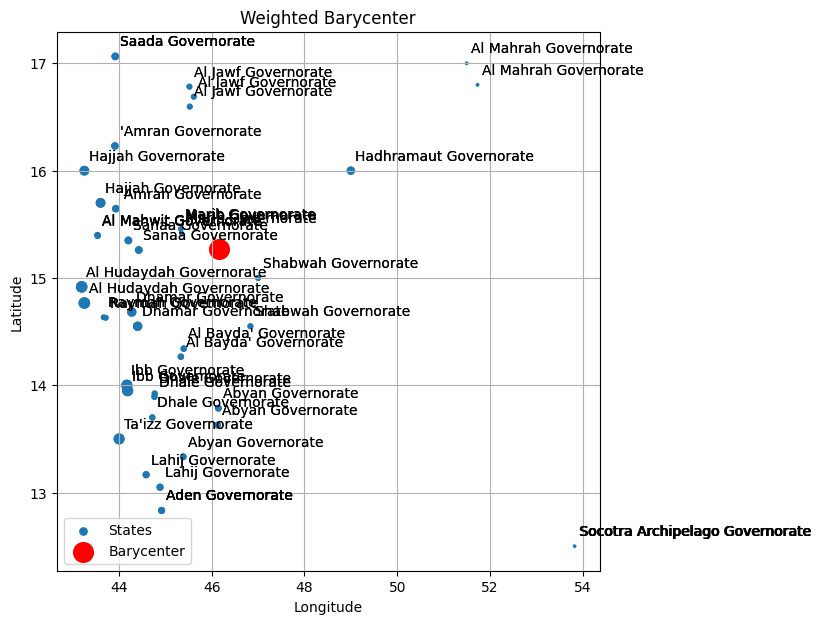

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [42]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [43]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,bary_longitude,distance_from_capital,country_y,bary_latitude_area,bary_longitude_area,distance_from_capital_area,country,bary_latitude_product,bary_longitude_product,distance_from_capital_product
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,44.523137,0.328361,Yemen,15.552624,47.163284,0.566924,Yemen,15.273508,46.159187,0.445479
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,37.640113,0.487495,Syria,35.079524,38.592676,0.636405,Syria,35.122388,38.293385,0.596107
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,68.081284,0.123911,Afghanistan,33.804540,66.137710,0.359218,Afghanistan,33.825971,66.250096,0.346062
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,96.115238,0.025748,Myanmar,20.812894,96.519827,0.152899,Myanmar,20.699824,96.614577,0.143491
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,36.558385,0.754927,Ukraine,46.798456,36.344099,0.758774,Ukraine,46.827137,36.380483,0.758347
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,11.636560,0.370236,Cameroon,5.824946,12.455481,0.351176,Cameroon,6.081337,12.255138,0.377624
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.250171,0.167128,Uganda,1.367365,32.227467,0.251740,Uganda,1.268228,32.222274,0.230975
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,44.528982,0.026776,Iraq,32.977813,43.756228,0.102947,Iraq,33.349602,43.570482,0.111954
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-9.776285,0.344864,Liberia,6.422572,-9.309127,0.496661,Liberia,6.582248,-9.392274,0.476331
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,36.494280,0.114932,Kenya,0.280827,37.978089,0.284432,Kenya,0.197799,37.738497,0.254761


# Data Analysis: 1 as weight

In [48]:

# -----------------------------
# Barycenter Solver
# ---------------------------
def compute_barycenter(lat, lon, weights=None):

    lat = np.asarray(lat)
    lon = np.asarray(lon)

    if weights is None:
        weights = np.ones_like(lat)

    lat_c = np.average(lat, weights=weights)
    lon_c = np.average(lon, weights=weights)

    return lat_c, lon_c


import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    srf = data["area"].values
    pop = data["population"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude_one": bary_lat,
        "bary_longitude_one": bary_lon,
        "distance_from_capital_one": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)


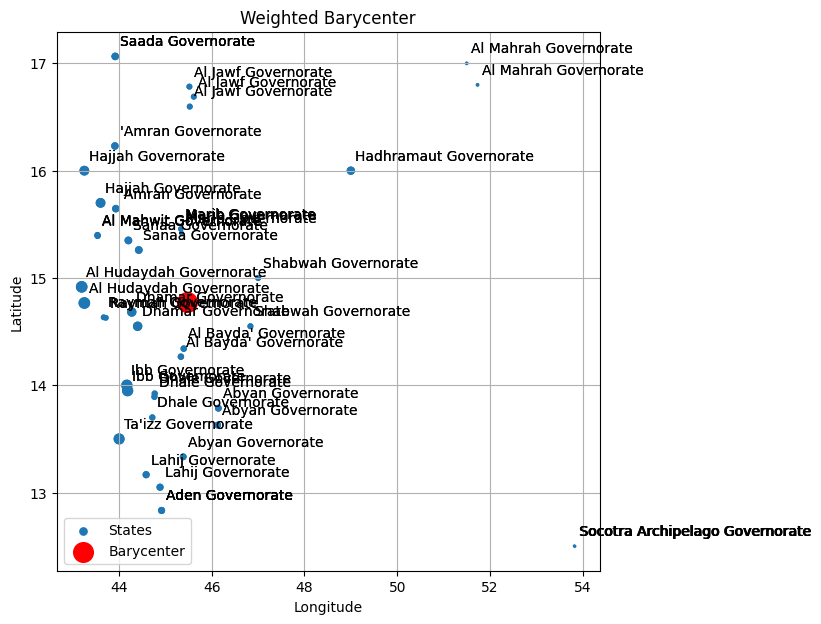

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [51]:
data_fsi.drop(columns=["country_x"], inplace=True)

In [52]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [53]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,bary_longitude_area,distance_from_capital_area,country_x,bary_latitude_product,bary_longitude_product,distance_from_capital_product,country_y,bary_latitude_one,bary_longitude_one,distance_from_capital_one
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,47.163284,0.566924,Yemen,15.273508,46.159187,0.445479,Yemen,14.779450,45.473000,0.333625
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,38.592676,0.636405,Syria,35.122388,38.293385,0.596107,Syria,34.721538,37.471026,0.401407
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,66.137710,0.359218,Afghanistan,33.825971,66.250096,0.346062,Afghanistan,34.462098,67.589643,0.179117
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,96.519827,0.152899,Myanmar,20.699824,96.614577,0.143491,Myanmar,19.602348,96.148902,0.020091
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,36.344099,0.758774,Ukraine,46.827137,36.380483,0.758347,Ukraine,46.636797,36.106667,0.759698
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,12.455481,0.351176,Cameroon,6.081337,12.255138,0.377624,Cameroon,5.822917,11.716667,0.318508
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.227467,0.251740,Uganda,1.268228,32.222274,0.230975,Uganda,1.064569,32.250791,0.185806
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,43.756228,0.102947,Iraq,33.349602,43.570482,0.111954,Iraq,33.374693,44.677602,0.044892
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-9.309127,0.496661,Liberia,6.582248,-9.392274,0.476331,Liberia,6.277778,-9.405556,0.463518
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,37.978089,0.284432,Kenya,0.197799,37.738497,0.254761,Kenya,-0.467990,36.716505,0.120257


# Data Analysis: p/d as weight

In [59]:
# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    pop,
    max_iter=1000,
    tol=1e-6,
):
    """
    Iterative weighted barycenter
    """

    # Initial guess: population-weighted center
    lat_c = np.average(lat, weights=pop)
    lon_c = np.average(lon, weights=pop)

    for i in range(max_iter):

        # Distances
        d = haversine(lat_c, lon_c, lat, lon)

        # Weights
        w = pop / d

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence test
        delta = np.sqrt(
            (lat_new - lat_c)**2 +
            (lon_new - lon_c)**2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            print(f"Converged in {i+1} iterations")
            break

    return lat_c, lon_c

import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    pop = data["population"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon, pop)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude_p/d": bary_lat,
        "bary_longitude_p/d": bary_lon,
        "distance_from_capital_p/d": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)

Converged in 81 iterations
Converged in 31 iterations
Converged in 12 iterations
Converged in 128 iterations
Converged in 21 iterations
Converged in 119 iterations
Converged in 11 iterations
Converged in 27 iterations
Converged in 21 iterations
Converged in 26 iterations
Converged in 40 iterations
Converged in 15 iterations
Converged in 48 iterations
Converged in 40 iterations
Converged in 42 iterations
Converged in 26 iterations
Converged in 60 iterations
Converged in 43 iterations
Converged in 24 iterations
Converged in 7 iterations
Converged in 68 iterations
Converged in 22 iterations
Converged in 40 iterations
Converged in 49 iterations
Converged in 32 iterations
Converged in 51 iterations
Converged in 9 iterations
Converged in 8 iterations
Converged in 25 iterations
Converged in 184 iterations
Converged in 3 iterations
Converged in 24 iterations
Converged in 124 iterations
Converged in 21 iterations
Converged in 65 iterations
Converged in 17 iterations
Converged in 45 iterations
C

/tmp/ipython-input-2053389919.py:25: RuntimeWarning: divide by zero encountered in divide
  w = pop / d
/tmp/ipython-input-2053389919.py:28: RuntimeWarning: invalid value encountered in scalar divide
  lat_new = np.sum(w * lat) / np.sum(w)
/tmp/ipython-input-2053389919.py:29: RuntimeWarning: invalid value encountered in scalar divide
  lon_new = np.sum(w * lon) / np.sum(w)


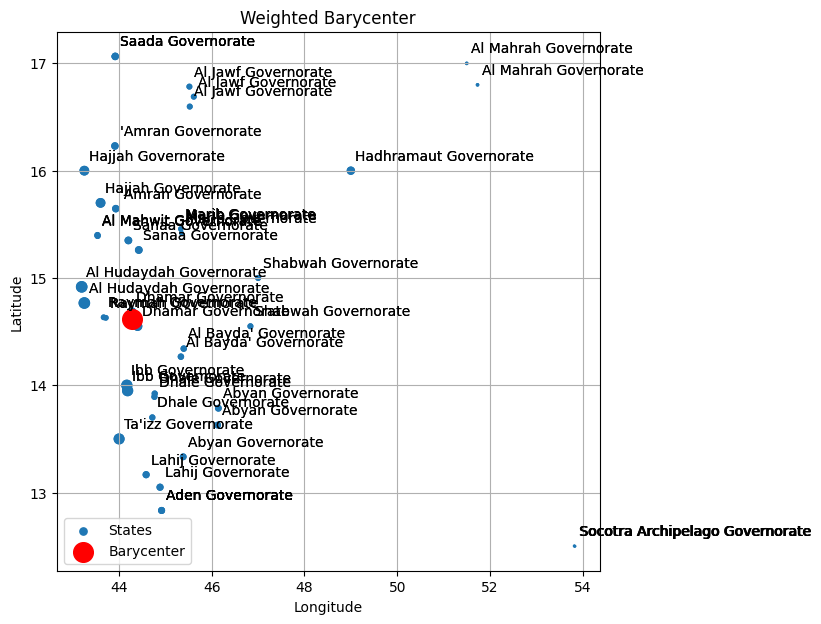

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [61]:
data_fsi.drop(columns=["country_x"], inplace=True)

In [62]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [63]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,bary_longitude_product,distance_from_capital_product,country_y,bary_latitude_one,bary_longitude_one,distance_from_capital_one,country,bary_latitude_p/d,bary_longitude_p/d,distance_from_capital_p/d
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,46.159187,0.445479,Yemen,14.779450,45.473000,0.333625,Yemen,14.613258,44.271182,3.226896e-01
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,38.293385,0.596107,Syria,34.721538,37.471026,0.401407,Syria,35.280059,37.349677,5.092395e-01
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,66.250096,0.346062,Afghanistan,34.462098,67.589643,0.179117,Afghanistan,34.559997,69.219993,7.195119e-03
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,96.614577,0.143491,Myanmar,19.602348,96.148902,0.020091,Myanmar,19.794588,95.757181,4.596302e-02
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,36.380483,0.758347,Ukraine,46.636797,36.106667,0.759698,Ukraine,48.008889,37.804166,7.644894e-01
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,12.255138,0.377624,Cameroon,5.822917,11.716667,0.318508,Cameroon,5.447919,10.578159,2.976212e-01
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.222274,0.230975,Uganda,1.064569,32.250791,0.185806,Uganda,0.316700,32.583332,8.616730e-04
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,43.570482,0.111954,Iraq,33.374693,44.677602,0.044892,Iraq,33.333333,44.433333,9.923373e-03
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-9.392274,0.476331,Liberia,6.277778,-9.405556,0.463518,Liberia,6.514937,-10.273378,1.886549e-01
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,37.738497,0.254761,Kenya,-0.467990,36.716505,0.120257,Kenya,-0.504491,36.008756,1.640192e-01


# Data Analysis: a/d as weight

In [64]:
# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    area,
    max_iter=1000,
    tol=1e-6,
):
    """
    Iterative weighted barycenter
    """

    # Initial guess: population-weighted center
    lat_c = np.average(lat, weights=area)
    lon_c = np.average(lon, weights=area)

    for i in range(max_iter):

        # Distances
        d = haversine(lat_c, lon_c, lat, lon)

        # Weights
        w = area / d

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence test
        delta = np.sqrt(
            (lat_new - lat_c)**2 +
            (lon_new - lon_c)**2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            print(f"Converged in {i+1} iterations")
            break

    return lat_c, lon_c

import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    area = data["area"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon, area)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude_a/d": bary_lat,
        "bary_longitude_a/d": bary_lon,
        "distance_from_capital_a/d": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)

Converged in 50 iterations
Converged in 22 iterations
Converged in 26 iterations
Converged in 50 iterations
Converged in 49 iterations
Converged in 27 iterations
Converged in 583 iterations
Converged in 22 iterations
Converged in 25 iterations
Converged in 60 iterations
Converged in 33 iterations
Converged in 217 iterations
Converged in 20 iterations
Converged in 33 iterations
Converged in 30 iterations
Converged in 23 iterations
Converged in 45 iterations
Converged in 23 iterations
Converged in 18 iterations
Converged in 39 iterations
Converged in 18 iterations
Converged in 180 iterations
Converged in 69 iterations
Converged in 19 iterations
Converged in 16 iterations
Converged in 3 iterations
Converged in 31 iterations
Converged in 28 iterations
Converged in 26 iterations
Converged in 19 iterations
Converged in 10 iterations
Converged in 91 iterations
Converged in 23 iterations
Converged in 26 iterations
Converged in 21 iterations
Converged in 7 iterations
Converged in 244 iterations

/tmp/ipython-input-511406331.py:25: RuntimeWarning: divide by zero encountered in divide
  w = area / d
/tmp/ipython-input-511406331.py:28: RuntimeWarning: invalid value encountered in scalar divide
  lat_new = np.sum(w * lat) / np.sum(w)
/tmp/ipython-input-511406331.py:29: RuntimeWarning: invalid value encountered in scalar divide
  lon_new = np.sum(w * lon) / np.sum(w)


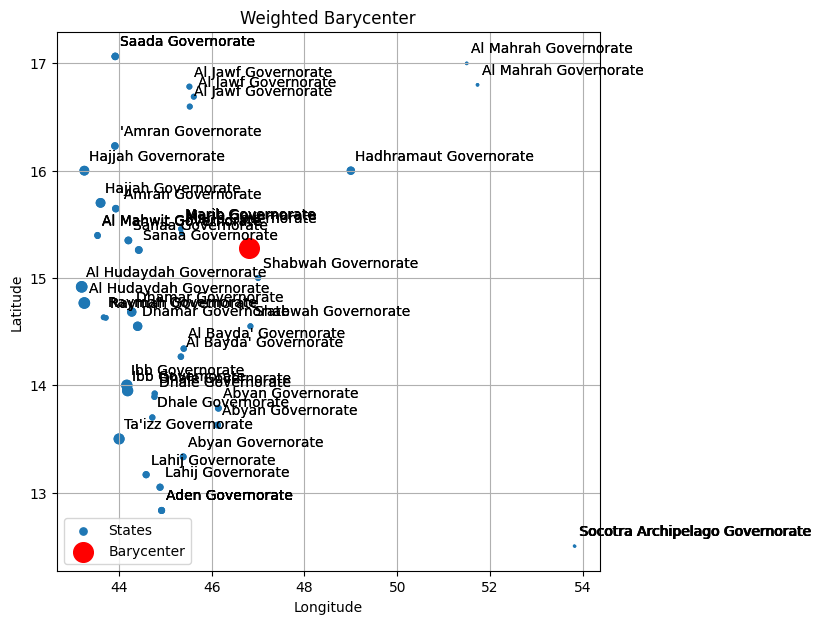

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [67]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [68]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,bary_longitude_one,distance_from_capital_one,country_x,bary_latitude_p/d,bary_longitude_p/d,distance_from_capital_p/d,country_y,bary_latitude_a/d,bary_longitude_a/d,distance_from_capital_a/d
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,45.473000,0.333625,Yemen,14.613258,44.271182,3.226896e-01,Yemen,15.278410,46.793394,0.495842
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,37.471026,0.401407,Syria,35.280059,37.349677,5.092395e-01,Syria,34.929607,38.521273,0.600687
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,67.589643,0.179117,Afghanistan,34.559997,69.219993,7.195119e-03,Afghanistan,33.714725,66.194950,0.356841
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,96.148902,0.020091,Myanmar,19.794588,95.757181,4.596302e-02,Myanmar,21.083137,96.205353,0.180920
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,36.106667,0.759698,Ukraine,48.008889,37.804166,7.644894e-01,Ukraine,48.008888,37.804165,0.764489
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,11.716667,0.318508,Cameroon,5.447919,10.578159,2.976212e-01,Cameroon,5.192071,12.620248,0.278736
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.250791,0.185806,Uganda,0.316700,32.583332,8.616730e-04,Uganda,1.838571,32.336590,0.349793
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,44.677602,0.044892,Iraq,33.333333,44.433333,9.923373e-03,Iraq,32.986281,43.246365,0.167106
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-9.405556,0.463518,Liberia,6.514937,-10.273378,1.886549e-01,Liberia,6.455203,-9.381425,0.473758
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,36.716505,0.120257,Kenya,-0.504491,36.008756,1.640192e-01,Kenya,0.234106,38.177511,0.297532


# Data Analysis: p * a / d as weight

In [69]:

# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    area,
    population,
    max_iter=1000,
    tol=1e-6,
):
    """
    Iterative weighted barycenter
    """

    # Initial guess: population-weighted center
    lat_c = np.average(lat, weights=area * population)
    lon_c = np.average(lon, weights=area * population)

    for i in range(max_iter):

        # Distances
        d = haversine(lat_c, lon_c, lat, lon)

        # Weights
        w = area * population / d

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence test
        delta = np.sqrt(
            (lat_new - lat_c)**2 +
            (lon_new - lon_c)**2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            print(f"Converged in {i+1} iterations")
            break

    return lat_c, lon_c

import pandas as pd

results = []

for c in data_all["country"].unique():
    data = data_all[data_all["country"] == c]

    # -----------------------------
    # Run Computation
    # -----------------------------
    lat = data["lat"].values
    lon = data["lon"].values
    srf = data["area"].values
    pop = data["population"].values

    bary_lat, bary_lon = compute_barycenter(lat, lon, srf, pop)

    distance = haversine(
        bary_lat, bary_lon,
        c_lat[c], c_long[c]
    ) / np.sqrt(c_area[c])

    # -----------------------------
    # Store Result
    # -----------------------------
    results.append({
        "country": c,
        "bary_latitude_p*a/d": bary_lat,
        "bary_longitude_p*a/d": bary_lon,
        "distance_from_capital_p*a/d": distance
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)


Converged in 25 iterations
Converged in 12 iterations
Converged in 7 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 39 iterations
Converged in 27 iterations
Converged in 18 iterations
Converged in 24 iterations
Converged in 32 iterations
Converged in 57 iterations
Converged in 34 iterations
Converged in 37 iterations
Converged in 12 iterations
Converged in 34 iterations
Converged in 24 iterations
Converged in 35 iterations
Converged in 25 iterations
Converged in 145 iterations
Converged in 11 iterations
Converged in 29 iterations
Converged in 56 iterations
Converged in 47 iterations
Converged in 65 iterations
Converged in 21 iterations
Converged in 4 iterations
Converged in 67 iterations
Converged in 31 iterations
Converged in 165 iterations
Converged in 24 iterations
Converged in 2 iterations
Converged in 24 iterations
Converged in 114 iterations
Converged in 14 iterations
Converged in 23 iterations
Converged in 7 iterations
Converged in 12 iterations
Co

/tmp/ipython-input-1177591571.py:26: RuntimeWarning: divide by zero encountered in divide
  w = area * population / d
/tmp/ipython-input-1177591571.py:29: RuntimeWarning: invalid value encountered in scalar divide
  lat_new = np.sum(w * lat) / np.sum(w)
/tmp/ipython-input-1177591571.py:30: RuntimeWarning: invalid value encountered in scalar divide
  lon_new = np.sum(w * lon) / np.sum(w)


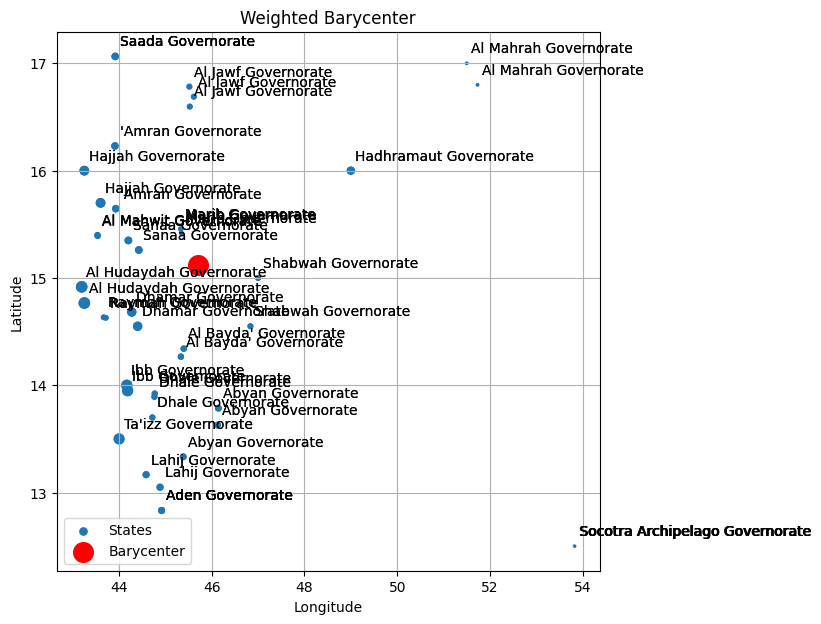

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [71]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [72]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,bary_longitude_p/d,distance_from_capital_p/d,country_y,bary_latitude_a/d,bary_longitude_a/d,distance_from_capital_a/d,country,bary_latitude_p*a/d,bary_longitude_p*a/d,distance_from_capital_p*a/d
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,44.271182,3.226896e-01,Yemen,15.278410,46.793394,0.495842,Yemen,15.117809,45.706056,3.967282e-01
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,37.349677,5.092395e-01,Syria,34.929607,38.521273,0.600687,Syria,34.915905,38.214410,5.478357e-01
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,69.219993,7.195119e-03,Afghanistan,33.714725,66.194950,0.356841,Afghanistan,33.705541,66.268321,3.493440e-01
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,95.757181,4.596302e-02,Myanmar,21.083137,96.205353,0.180920,Myanmar,21.110761,96.733428,2.002516e-01
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,37.804166,7.644894e-01,Ukraine,48.008888,37.804165,0.764489,Ukraine,48.008888,37.804165,7.644894e-01
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,10.578159,2.976212e-01,Cameroon,5.192071,12.620248,0.278736,Cameroon,4.930641,11.826527,1.799826e-01
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.583332,8.616730e-04,Uganda,1.838571,32.336590,0.349793,Uganda,0.903192,32.456870,1.364644e-01
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,44.433333,9.923373e-03,Iraq,32.986281,43.246365,0.167106,Iraq,33.352931,42.926371,2.024128e-01
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-10.273378,1.886549e-01,Liberia,6.455203,-9.381425,0.473758,Liberia,6.656585,-9.400292,4.790419e-01
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,36.008756,1.640192e-01,Kenya,0.234106,38.177511,0.297532,Kenya,-0.028241,37.742393,2.277526e-01


#Data Analysis: 1/d as weight

In [73]:
import numpy as np
import pandas as pd

# -----------------------------
# Barycenter Solver
# -----------------------------
def compute_barycenter(
    lat,
    lon,
    weights=None,
    max_iter=1000,
    tol=1e-6,
):
    """
    Compute geographic barycenter.

    Parameters
    ----------
    lat : array-like
    lon : array-like
    weights : array-like or None
        Optional weights (population, area, etc.)
    max_iter : int
    tol : float

    Returns
    -------
    (lat_c, lon_c) : tuple of floats
    """

    lat = np.asarray(lat, dtype=float)
    lon = np.asarray(lon, dtype=float)

    if weights is None:
        weights = np.ones_like(lat)
    else:
        weights = np.asarray(weights, dtype=float)

    # Initial guess: weighted average
    lat_c = np.average(lat, weights=weights)
    lon_c = np.average(lon, weights=weights)

    for i in range(max_iter):

        # Distance from current center
        d = haversine(lat_c, lon_c, lat, lon)

        # Avoid division by zero
        d = np.maximum(d, 1e-12)

        # Example iterative weight update (optional)
        # Comment this line if fixed weights are desired
        w = weights / d

        # New barycenter
        lat_new = np.sum(w * lat) / np.sum(w)
        lon_new = np.sum(w * lon) / np.sum(w)

        # Convergence check
        delta = np.sqrt(
            (lat_new - lat_c) ** 2 +
            (lon_new - lon_c) ** 2
        )

        lat_c, lon_c = lat_new, lon_new

        if delta < tol:
            break

    return lat_c, lon_c


# -----------------------------
# Run computation by country
# -----------------------------
results = []

for country in data_all["country"].unique():

    data = data_all[data_all["country"] == country]

    lat = data["lat"].values
    lon = data["lon"].values
    pop = data["population"].values

    # Use population weighting (recommended)
    bary_lat, bary_lon = compute_barycenter(
        lat,
        lon,
        weights=pop
    )

    distance = haversine(
        bary_lat,
        bary_lon,
        c_lat[country],
        c_long[country]
    ) / np.sqrt(c_area[country])

    results.append({
        "country": country,
        "bary_latitude_1/d": bary_lat,
        "bary_longitude_1/d": bary_lon,
        "distance_from_capital_1/d": distance,
    })

# Convert to DataFrame
barycenter_df = pd.DataFrame(results)

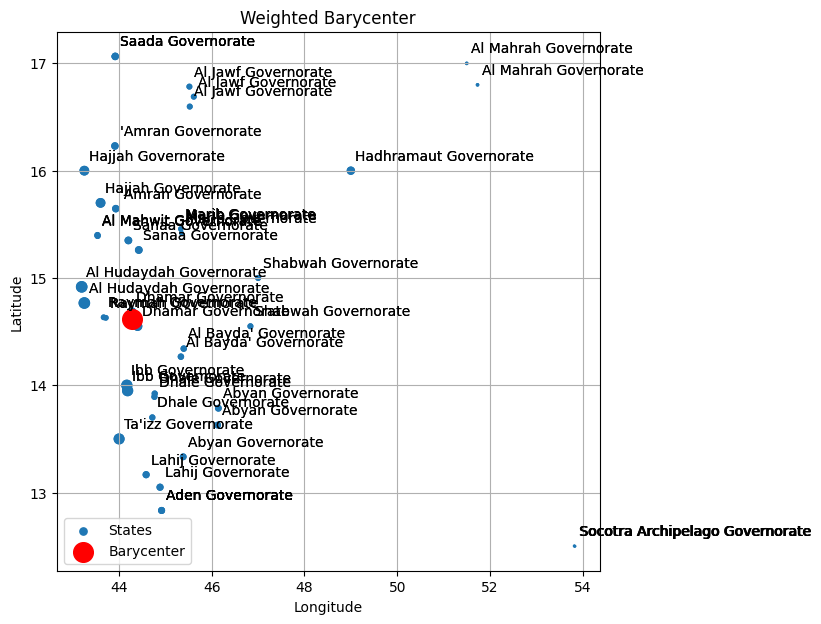

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

plt.scatter(lon, lat, s=pop/50000, label="States")
plt.scatter(bary_lon, bary_lat, color="red", s=200, label="Barycenter")

for i, name in enumerate(data["state"]):
    plt.text(lon[i]+0.1, lat[i]+0.1, name)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted Barycenter")
plt.legend()
plt.grid()

plt.show()

In [76]:
data_fsi.drop(columns=["country_x"], inplace=True)

In [77]:
data_fsi = pd.merge(data_fsi, barycenter_df, left_on='Country', right_on='country', how='left')

In [78]:
data_fsi

,Country,Year,Rank,Total,S1: Demographic Pressures,S2: Refugees and IDPs,C3: Group Grievance,E3: Human Flight and Brain Drain,E2: Economic Inequality,E1: Economy,...,bary_longitude_a/d,distance_from_capital_a/d,country_x,bary_latitude_p*a/d,bary_longitude_p*a/d,distance_from_capital_p*a/d,country_y,bary_latitude_1/d,bary_longitude_1/d,distance_from_capital_1/d
0,Yemen,2023,2nd,108.9,9.6,9.6,8.8,6.4,7.9,9.9,...,46.793394,0.495842,Yemen,15.117809,45.706056,3.967282e-01,Yemen,14.613258,44.271182,3.226896e-01
1,Syria,2023,5th,107.1,7.4,9.1,9.1,8.0,6.5,9.6,...,38.521273,0.600687,Syria,34.915905,38.214410,5.478357e-01,Syria,35.280059,37.349677,5.092395e-01
2,Afghanistan,2023,6th,106.6,9.2,8.6,8.3,8.5,8.2,9.6,...,66.194950,0.356841,Afghanistan,33.705541,66.268321,3.493440e-01,Afghanistan,34.559997,69.219993,7.195119e-03
3,Myanmar,2023,12th,100.2,7.0,9.2,9.7,6.3,7.3,7.6,...,96.205353,0.180920,Myanmar,21.110761,96.733428,2.002516e-01,Myanmar,19.794588,95.757181,4.596302e-02
4,Ukraine,2023,18th,95.9,7.3,10.0,6.8,8.9,4.9,8.5,...,37.804165,0.764489,Ukraine,48.008888,37.804165,7.644894e-01,Ukraine,48.008889,37.804166,7.644894e-01
5,Cameroon,2023,23rd,94.0,9.0,8.4,8.1,6.9,7.4,6.0,...,12.620248,0.278736,Cameroon,4.930641,11.826527,1.799826e-01,Cameroon,5.447919,10.578159,2.976212e-01
6,Uganda,2023,26th,91.5,9.2,8.9,7.6,6.1,7.4,6.4,...,32.336590,0.349793,Uganda,0.903192,32.456870,1.364644e-01,Uganda,0.316700,32.583332,8.616730e-04
7,Iraq,2023,27th,91.4,8.2,7.7,8.0,6.1,5.7,6.3,...,43.246365,0.167106,Iraq,33.352931,42.926371,2.024128e-01,Iraq,33.333333,44.433333,9.923373e-03
8,Liberia,2023,33rd,88.9,8.4,7.4,4.6,6.7,7.5,8.3,...,-9.381425,0.473758,Liberia,6.656585,-9.400292,4.790419e-01,Liberia,6.514937,-10.273378,1.886549e-01
9,Kenya,2023,35th,87.8,8.1,7.3,8.0,6.4,7.4,6.4,...,38.177511,0.297532,Kenya,-0.028241,37.742393,2.277526e-01,Kenya,-0.504491,36.008756,1.640192e-01


In [79]:
data_fsi.to_excel("Country_Data_Final.xlsx", index=False)